In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%pip install imutils

In [2]:
from imutils import paths
import random
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import *
from torch.utils.data import *
from torch import optim
import torch.nn as nn
import numpy as np
import argparse
import torch
import time
import cv2
import os
from PIL import Image, ImageDraw, ImageFont
import sys

# Prelims

In [4]:
CHARS = [
         '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
         'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
         'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
         'U', 'V', 'W', 'X', 'Y', 'Z'
         ]

CHARS_DICT = {char:i for i, char in enumerate(CHARS)}

In [5]:
def get_size(imgpath):
    shapeslist=[]
    for img in os.listdir(imgpath):
        try:
            im = Image.open(imgpath+"/"+img)
            shapeslist.append(im.size)
        except:
            pass
    a = np.array(shapeslist)
    heights = a.T[0]
    widths = a.T[1]
    heights.sort()
    widths.sort()
    img_h = int(np.median(heights))
    img_w = int(np.median(widths))
    return((img_h,img_w))

In [6]:
def collate_fn(batch):
    imgs = []
    labels = []
    lengths = []
    for _, sample in enumerate(batch):
        img, label, length = sample
        imgs.append(torch.from_numpy(img))
        labels.extend(label)
        lengths.append(length)
    labels = np.asarray(labels).flatten().astype(np.float32)

    return (torch.stack(imgs, 0), torch.from_numpy(labels), lengths)

In [121]:
class LPRDataLoader(Dataset):
    def __init__(self, img_dir, imgSize, lpr_max_len, PreprocFun=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in paths.list_images(img_dir[i])]
        print("1dir found, size: ",len(self.img_paths))
        random.shuffle(self.img_paths)
        self.img_size = imgSize
        self.lpr_max_len = lpr_max_len
        if PreprocFun is not None:
            self.PreprocFun = PreprocFun
        else:
            self.PreprocFun = self.transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        filename = self.img_paths[index]
        try:
            Image = cv2.imread(filename)
            if Image is None:
                raise ValueError(f"Image at {filename} could not be loaded.")
            Image = cv2.resize(Image, self.img_size)
            Image = self.PreprocFun(Image)
            basename = os.path.basename(filename)
            imgname, suffix = os.path.splitext(basename)
            imgname = ''.join(e for e in imgname if e.isalnum())
            label = [CHARS_DICT[c] for c in imgname.upper() if c in CHARS_DICT]

            if not self.check(label):
                print(f"Invalid label for image {filename}: {label}")
                return None  # Skip this sample

            return Image, label, len(label)

        except Exception as e:
            print(f"Error in image: {filename}, Error: {e}")
            return None  # or handle it differently

            
    
    def transform(self, img):
        img = img.astype('float32')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img -= 127.5
        img *= 0.0078125
        #thresh, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
        img = np.reshape(img, img.shape + (1,))
        img = np.transpose(img, (2, 0, 1))
        return img

    def check(self, label):
        if len(label)<4:
            print("Error label, Please check!")
            return False
        else:
            return True

# LPRNet

In [8]:
import torch.nn as nn
import torch

class small_basic_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(small_basic_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch_in, ch_out // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out, kernel_size=1),
        )
    def forward(self, x):
        return self.block(x)

class LPRNet(nn.Module):
    def __init__(self, lpr_max_len, phase, class_num, dropout_rate):
        super(LPRNet, self).__init__()
        torch.cuda.empty_cache()
        self.phase = phase
        self.lpr_max_len = lpr_max_len
        self.class_num = class_num
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1), # 0
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),  # 2
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1)),
            small_basic_block(ch_in=64, ch_out=128),    # *** 4 ***
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),  # 6
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2)),
            small_basic_block(ch_in=64, ch_out=256),   # 8
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 10
            small_basic_block(ch_in=256, ch_out=256),   # *** 11 ***
            nn.BatchNorm2d(num_features=256),   # 12
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(4, 1, 2)),  # 14
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 4), stride=1),  # 16
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 18
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=256, out_channels=class_num, kernel_size=(13, 1), stride=1), # 20
            nn.BatchNorm2d(num_features=class_num),
            nn.ReLU(),  # *** 22 ***
        )
        self.container = nn.Sequential(
            nn.Conv2d(in_channels=448+self.class_num, out_channels=self.class_num, kernel_size=(1, 1), stride=(1, 1)),
            # nn.BatchNorm2d(num_features=self.class_num),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=self.class_num, out_channels=self.lpr_max_len+1, kernel_size=3, stride=2),
            # nn.ReLU(),
        )

    def forward(self, x):
        keep_features = list()
        for i, layer in enumerate(self.backbone.children()):
            x = layer(x)
            if i in [2, 6, 13, 22]: # [2, 4, 8, 11, 22]
                keep_features.append(x)

        global_context = list()
        for i, f in enumerate(keep_features):
            if i in [0, 1]:
                f = nn.AvgPool2d(kernel_size=5, stride=5)(f)
            if i in [2]:
                f = nn.AvgPool2d(kernel_size=(4, 10), stride=(4, 2))(f)
            f_pow = torch.pow(f, 2)
            f_mean = torch.mean(f_pow)
            f = torch.div(f, f_mean)
            global_context.append(f)

        x = torch.cat(global_context, 1)
        x = self.container(x)
        logits = torch.mean(x, dim=2)

        return logits

def build_lprnet(lpr_max_len=15, phase=False, class_num=36, dropout_rate=0.5):

    Net = LPRNet(lpr_max_len, phase, class_num, dropout_rate)

    if phase == "train":
        return Net.train()
    else:
        return Net.eval()

In [9]:
print(torch.cuda.is_available())

True


# Preprocess

In [31]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2 as cv
from PIL import Image
import argparse
import re

In [63]:
def label_check(label):
    if len(label) < 8:
        return 0

    if label[0:2] == 'DL':
        delhi_pt = r"\d{4,4}$"  # Use raw string for regex
        dlval = re.search(delhi_pt, label)
        if dlval is None or len(dlval.group()) < 8:
            return 0
        else:
            return 1
    
    # General pattern for license plates
    pattern = r"(([A-Za-z]{2,3})(-?)([0-9]{1,2})(-?)([A-Za-z]{1,3})(-?)([0-9]{1,4}))|(([A-Za-z]{2,3})(-?)([0-9]{1,4}))"
    val = re.search(pattern, label)
    if val is None or len(val.group()) < 8:
        return 0
    else:
        return 1

Total images processed: 973
Min Width: 20
Max Width: 170
Average Width: 89.79
Median Width: 94.0


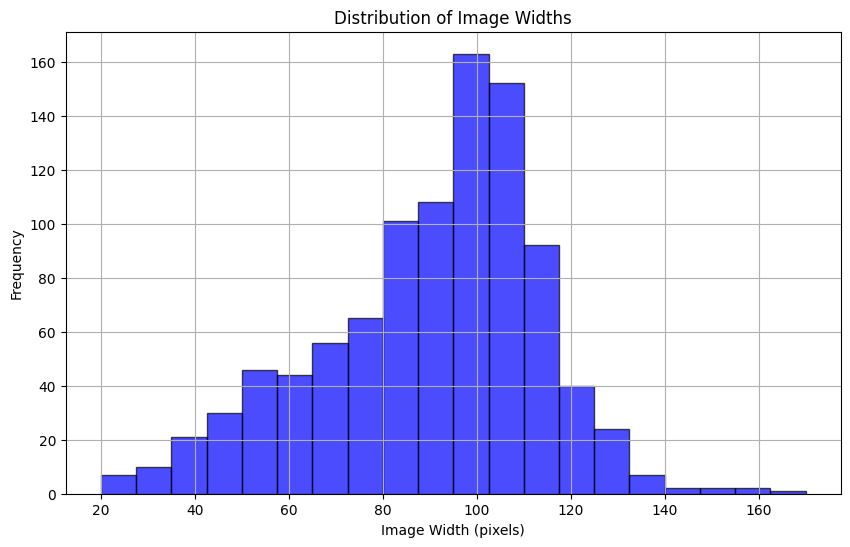

In [64]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def summarize_image_widths(image_dir):
    image_widths = []

    # Iterate through all image files in the directory
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Add other image formats if needed
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                
                if img is not None:
                    height, width, _ = img.shape
                    image_widths.append(width)
                else:
                    print(f"Error loading image: {img_path}")

    # Calculate statistics
    if len(image_widths) == 0:
        print("No images found in the directory.")
        return

    min_width = np.min(image_widths)
    max_width = np.max(image_widths)
    avg_width = np.mean(image_widths)
    median_width = np.median(image_widths)

    print(f"Total images processed: {len(image_widths)}")
    print(f"Min Width: {min_width}")
    print(f"Max Width: {max_width}")
    print(f"Average Width: {avg_width:.2f}")
    print(f"Median Width: {median_width}")

    # Plot a histogram to visualize width variation
    plt.figure(figsize=(10, 6))
    plt.hist(image_widths, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Image Widths')
    plt.xlabel('Image Width (pixels)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    return {
        'min_width': min_width,
        'max_width': max_width,
        'avg_width': avg_width,
        'median_width': median_width
    }

# Example usage
image_dir = '/kaggle/input/images/images'  # Replace with your image directory path
summary = summarize_image_widths(image_dir)


In [74]:
import cv2
import os
import numpy as np

def pad_image(image, target_width):
    """Pad the image to the target width."""
    height, width = image.shape[:2]
    if width < target_width:
        # Calculate the padding needed on each side
        padding = (target_width - width) // 2
        image = cv.copyMakeBorder(image, 0, 0, padding, padding, cv.BORDER_CONSTANT, value=(0, 0, 0))
    return image

def resize_image_to_target(image, target_size=(94, 24)):
    """Resize the image to the target size if its width is larger."""
    height, width = image.shape[:2]
    if width > target_size[0]:
        # Resize image while keeping the aspect ratio
        image = cv.resize(image, target_size, interpolation=cv.INTER_AREA)
    
    return image

In [75]:
import shutil
import os

def clear_working_directory():
    working_dir = '/kaggle/working'
    
    # Iterate through all files and directories in the working directory
    for filename in os.listdir(working_dir):
        file_path = os.path.join(working_dir, filename)
        
        try:
            # Check if it's a file or directory and delete accordingly
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file
#                 print(f"Deleted file: {file_path}")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and all its contents
#                 print(f"Deleted directory: {file_path}")
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Run the function to clear the working directory
clear_working_directory()


In [80]:
def preprocess():
    odr = os.path.expanduser('/kaggle/input/images/images')
    writable_dir = '/kaggle/working/processed_images'
    optimal_min_width = 100  # Modal width

    # Create writable directory if it doesn't exist
    if not os.path.exists(writable_dir):
        os.makedirs(writable_dir)

    if not os.path.exists(odr):
        print(f"Directory does not exist: {odr}")
        return

    total_images = 0
    discarded_count = 0

    print(f"Processing images in the directory: {odr}")

    for dirs in os.listdir(odr):
        dir_path = os.path.join(odr, dirs)
        if not os.path.isdir(dir_path):
            print(f"Skipping non-directory item: {dirs}")
            continue

        # Create corresponding directory in writable directory
        writable_subdir = os.path.join(writable_dir, dirs)
        if not os.path.exists(writable_subdir):
            os.makedirs(writable_subdir)

        for img in os.listdir(dir_path):
            total_images += 1
            ipath = os.path.join(dir_path, img)
            img_name, _ = os.path.splitext(img)  # Get base image name without extension

            # The label is now the same as the filename without extension
            label = img_name

            # Perform label check
            if not label_check(label):
                print(f"Invalid label: {label}. Discarding image: {img}")
                discarded_count += 1
                continue

            # Read the image using OpenCV
            image = cv.imread(ipath)
            if image is None:
                print(f"Failed to load image: {img}. Discarding.")
                discarded_count += 1
                continue

            # Check size and pad if necessary
            height, width = image.shape[:2]
            # Pad or resize image based on its width
            if width < optimal_min_width:
                image = pad_image(image, optimal_min_width)  # Pad the image if below target width
            elif width > optimal_min_width:
                image = resize_image_to_target(image) 

            # Clean the label and create a new file path in writable directory
            label_clean = ''.join(e for e in label if e.isalnum())
            tpath = os.path.join(writable_subdir, f"{label_clean}.jpg")  # Assuming '.jpg' extension

            # Check if target path already exists
            if os.path.exists(tpath):
                # If both files exist, compare sizes before discarding one
                if os.path.getsize(tpath) == os.path.getsize(ipath):
                    print(f"Duplicate found, keeping original: {img}")
                    continue
                else:
                    print(f"Replacing duplicate with smaller file: {img}")
                    os.remove(tpath)  # Remove the existing larger file

            # Save the processed image to writable directory
            try:
                cv.imwrite(tpath, image)
                print(f"Saved {tpath}")
            except Exception as e:
                print(f"Error saving image: {img}. Reason: {e}")
                continue

    print(f"Processed {total_images} images.")
    print(f"Discarded {discarded_count} images due to invalid label or size.")


In [81]:
preprocess()

Processing images in the directory: /kaggle/input/images/images
Saved /kaggle/working/processed_images/test/AS04P4549.jpg
Saved /kaggle/working/processed_images/test/JH01BC5210.jpg
Saved /kaggle/working/processed_images/test/MH05EJ3005.jpg
Saved /kaggle/working/processed_images/test/UP78ED0449.jpg
Saved /kaggle/working/processed_images/test/AP5CG6320.jpg
Saved /kaggle/working/processed_images/test/MH12KY6921.jpg
Saved /kaggle/working/processed_images/test/RJ20UB0137.jpg
Saved /kaggle/working/processed_images/test/WB02M8447.jpg
Saved /kaggle/working/processed_images/test/DN09C0868.jpg
Saved /kaggle/working/processed_images/test/GA01S5594.jpg
Saved /kaggle/working/processed_images/test/MH01DB2561.jpg
Saved /kaggle/working/processed_images/test/ML05C5389.jpg
Saved /kaggle/working/processed_images/test/OD05Y5787.jpg
Saved /kaggle/working/processed_images/test/CG07MA2529.jpg
Saved /kaggle/working/processed_images/test/UK07AM5665.jpg
Invalid label: WB171717. Discarding image: WB171717.jpg
Sa

# Training

In [142]:
def sparse_tuple_for_ctc(T_length, lengths):
    input_lengths = []
    target_lengths = []

    for ch in lengths:
        input_lengths.append(T_length)
        target_lengths.append(ch)

    return tuple(input_lengths), tuple(target_lengths)

def adjust_learning_rate(optimizer, cur_epoch, base_lr, lr_schedule):
    lr = 0
#     print("Original learning rate schedule:", lr_schedule)

    # Convert all valid elements to integers
    valid_lr_schedule = []
    for e in lr_schedule:
        try:
            valid_lr_schedule.append(int(e))
        except ValueError:
            print(f"Skipping non-numeric value: {e}")

    for i, e in enumerate(valid_lr_schedule):
        if cur_epoch < e:
            lr = base_lr * (0.1 ** i)
            break
    
    # Update the learning rate for the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    return lr



In [164]:
import argparse
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import sys

# Example of modified argument parsing
def get_parser():
    parser = argparse.ArgumentParser(description='Parameters to train the LPRNet model.')
    
    parser.add_argument('--max_epoch', type=int, default=50)
    parser.add_argument('--img_size', type=int, nargs=2, default=(94, 24),
                        help='The image size as two integers, width and height.')
    parser.add_argument('--train_img_dirs', type=str, default='/kaggle/working/processed_images/train')
    parser.add_argument('--test_img_dirs', type=str, default='/kaggle/working/processed_images/test')
    parser.add_argument('--dropout_rate', type=float, default=0.5)
    parser.add_argument('--learning_rate', type=float, default=0.001)
    parser.add_argument('--lpr_max_len', type=int, default=18)
    parser.add_argument('--train_batch_size', type=int, default=32)
    parser.add_argument('--test_batch_size', type=int, default=32)
    parser.add_argument('--phase_train', type=str, default='train')
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--cuda', action='store_true', default=False)
    parser.add_argument('--resume_epoch', type=int, default=0)
    parser.add_argument('--save_interval', type=int, default=100)
    parser.add_argument('--test_interval', type=int, default=100)
    parser.add_argument('--momentum', type=float, default=0.9)
    parser.add_argument('--weight_decay', type=float, default=1e-4)
    parser.add_argument('--lr_schedule', type= list[int], default = [20, 40])  # Epochs where the learning rate will decay
    parser.add_argument('--show', type=bool, default=True,
                        help='Displays images with labels and targets.')
    parser.add_argument('--save_folder', type=str, default='./saved_models/')
    parser.add_argument('--pretrained_model', type=str, default='/kaggle/input/pretrained/Final_LPRNet_model.pth')

    # Check if we are running in Jupyter Notebook
    if 'ipykernel' in sys.modules:
        return parser.parse_args([])  # Parse with no arguments

    return parser.parse_args()  # Normal parsing for command line

In [168]:
def Greedy_Decode_Eval(Net, datasets, args):
    epoch_size = len(datasets) // args.test_batch_size
    batch_iterator = iter(DataLoader(datasets, args.test_batch_size, shuffle=True, num_workers=args.num_workers, collate_fn=collate_fn))

    Tp = 0
    Tn_1 = 0
    Tn_2 = 0
    t1 = time.time()
    
    # Counter for limiting the number of displayed images
    images_shown = 0
    max_images_to_show = 2

    for i in range(epoch_size):
        images, labels, lengths = next(batch_iterator)
        start = 0

        # Creating targets as an object array to accommodate varying lengths
        targets = np.empty(len(lengths), dtype=object)
        for idx, length in enumerate(lengths):
            targets[idx] = labels[start:start + length]
            start += length
        
        imgs = images.numpy().copy()

        if args.cuda:
            images = Variable(images.cuda())
        else:
            images = Variable(images)

        # Forward pass
        prebs = Net(images)
        prebs = prebs.cpu().detach().numpy()
        preb_labels = []

        for i in range(prebs.shape[0]):
            preb = prebs[i, :, :]
            preb_label = []
            for j in range(preb.shape[1]):
                preb_label.append(np.argmax(preb[:, j], axis=0))
            no_repeat_blank_label = []
            pre_c = preb_label[0]
            if pre_c != len(CHARS) - 1:
                no_repeat_blank_label.append(pre_c)
            for c in preb_label:
                if (pre_c == c) or (c == len(CHARS) - 1):
                    if c == len(CHARS) - 1:
                        pre_c = c
                    continue
                no_repeat_blank_label.append(c)
                pre_c = c
            preb_labels.append(no_repeat_blank_label)

        for i, label in enumerate(preb_labels):
            # Show image only if images_shown is less than max_images_to_show
            if args.show and images_shown < max_images_to_show:
                print(f"Showing image {i}, label: {label}, target: {targets[i]}")
                if imgs[i].shape[0] == 0 or imgs[i].shape[1] == 0:
                    print(f"Empty image at index {i}, skipping...")
                    continue
                show(imgs[i], label, targets[i])
                images_shown += 1  # Increment counter

            if len(label) != len(targets[i]):
                Tn_1 += 1
                continue
            if (np.asarray(targets[i]) == np.asarray(label)).all():
                Tp += 1
            else:
                Tn_2 += 1

        # Break the loop early if the desired number of images has been shown
        if images_shown >= max_images_to_show:
            break

    total_predictions = Tp + Tn_1 + Tn_2
    Acc = Tp * 1.0 / total_predictions if total_predictions > 0 else 0.0

    print("[Info] Test Accuracy: {} [{}:{}:{}:{}]".format(Acc, Tp, Tn_1, Tn_2, total_predictions))
    t2 = time.time()
    print("[Info] Test Speed: {}s 1/{}]".format((t2 - t1) / len(datasets), len(datasets)))

In [169]:
def train():
    args = get_parser()

    T_length = 18 # args.lpr_max_len
    epoch = 0 + args.resume_epoch
    loss_val = 0

    if not os.path.exists(args.save_folder):
        os.mkdir(args.save_folder)

    lprnet = build_lprnet(lpr_max_len=args.lpr_max_len, phase=args.phase_train, class_num=len(CHARS), dropout_rate=args.dropout_rate)
    device = torch.device("cuda:0" if args.cuda else "cpu")
    lprnet.to(device)
    print("Successful to build network!")

    # load pretrained model
    if args.pretrained_model:
        lprnet.load_state_dict(torch.load(args.pretrained_model))
        print("load pretrained model successful!")
    else:
        def xavier(param):
            nn.init.xavier_uniform(param)

        def weights_init(m):
            for key in m.state_dict():
                if key.split('.')[-1] == 'weight':
                    if 'conv' in key:
                        nn.init.kaiming_normal_(m.state_dict()[key], mode='fan_out')
                    if 'bn' in key:
                        m.state_dict()[key][...] = xavier(1)
                elif key.split('.')[-1] == 'bias':
                    m.state_dict()[key][...] = 0.01

        lprnet.backbone.apply(weights_init)
        lprnet.container.apply(weights_init)
        print("initial net weights successful!")

    # define optimizer
    # optimizer = optim.SGD(lprnet.parameters(), lr=args.learning_rate,
    #                       momentum=args.momentum, weight_decay=args.weight_decay)
    optimizer = optim.RMSprop(lprnet.parameters(), lr=args.learning_rate, alpha = 0.9, eps=1e-08,
                         momentum=args.momentum, weight_decay=args.weight_decay)
    train_img_dirs = os.path.expanduser(args.train_img_dirs)
    test_img_dirs = os.path.expanduser(args.test_img_dirs)
    #train_imgsize = get_size(train_img_dirs)
    #test_imgsize = get_size(test_img_dirs)
    train_dataset = LPRDataLoader(train_img_dirs.split(','), args.img_size, args.lpr_max_len)
    test_dataset = LPRDataLoader(test_img_dirs.split(','), args.img_size, args.lpr_max_len)

    epoch_size = len(train_dataset) // args.train_batch_size
    max_iter = args.max_epoch * epoch_size
    
    print(epoch_size, max_iter)
    
    ctc_loss = nn.CTCLoss(blank=len(CHARS)-1, reduction='mean') # reduction: 'none' | 'mean' | 'sum'

    if args.resume_epoch > 0:
        start_iter = args.resume_epoch * epoch_size
    else:
        start_iter = 0

    for iteration in range(start_iter, max_iter):
        if iteration % epoch_size == 0:
            # create batch iterator
            batch_iterator = iter(DataLoader(train_dataset, args.train_batch_size, shuffle=True, num_workers=args.num_workers, collate_fn=collate_fn))
            loss_val = 0
            epoch += 1

        if iteration !=0 and iteration % args.save_interval == 0:
            torch.save(lprnet.state_dict(), args.save_folder + 'LPRNet_' + '_iteration_' + repr(iteration) + '.pth')

        if (iteration + 1) % args.test_interval == 0:
            Greedy_Decode_Eval(lprnet, test_dataset, args)
            # lprnet.train() # should be switch to train mode

        start_time = time.time()
        # load train data
        images, labels, lengths = next(batch_iterator)
        # labels = np.array([el.numpy() for el in labels]).T
        # get ctc parameters
        input_lengths, target_lengths = sparse_tuple_for_ctc(T_length, lengths)
        # update lr
        lr = adjust_learning_rate(optimizer, epoch, args.learning_rate, args.lr_schedule)

        if args.cuda:
            images = Variable(images, requires_grad=False).cuda()
            labels = Variable(labels, requires_grad=False).cuda()
        else:
            images = Variable(images, requires_grad=False)
            labels = Variable(labels, requires_grad=False)

        # forward
        logits = lprnet(images)
        log_probs = logits.permute(2, 0, 1) # for ctc loss: T x N x C
        log_probs = log_probs.log_softmax(2).requires_grad_()
        # log_probs = log_probs.detach().requires_grad_()
        # backprop
        optimizer.zero_grad()
        loss = ctc_loss(log_probs, labels, input_lengths=input_lengths, target_lengths=target_lengths)
        if loss.item() == np.inf:
            continue
        loss.backward()
        optimizer.step()
        loss_val += loss.item()
        end_time = time.time()
        if iteration % 20 == 0:
            print('Epoch:' + repr(epoch) + ' || epochiter: ' + repr(iteration % epoch_size) + '/' + repr(epoch_size)
                  + '|| Totel iter ' + repr(iteration) + ' || Loss: %.4f||' % (loss.item()) +
                  'Batch time: %.4f sec. ||' % (end_time - start_time) + 'LR: %.8f' % (lr))
    # final test
    print("Final test Accuracy:")
    Greedy_Decode_Eval(lprnet, test_dataset, args)

    # save final parameters
    torch.save(lprnet.state_dict(), args.save_folder + 'Final_LPRNet_model.pth')

Successful to build network!
load pretrained model successful!
1dir found, size:  771
1dir found, size:  88
24 1200


/tmp/ipykernel_92/1242552846.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lprnet.load_state_dict(torch.load(args.pretrained_model))


Epoch:1 || epochiter: 0/24|| Totel iter 0 || Loss: 66.2419||Batch time: 1.7058 sec. ||LR: 0.00100000
Epoch:1 || epochiter: 20/24|| Totel iter 20 || Loss: 47.1621||Batch time: 0.5917 sec. ||LR: 0.00100000
Epoch:2 || epochiter: 16/24|| Totel iter 40 || Loss: 35.4554||Batch time: 0.5979 sec. ||LR: 0.00100000
Epoch:3 || epochiter: 12/24|| Totel iter 60 || Loss: 26.5908||Batch time: 0.5813 sec. ||LR: 0.00100000
Epoch:4 || epochiter: 8/24|| Totel iter 80 || Loss: 27.5805||Batch time: 0.5720 sec. ||LR: 0.00100000
Showing image 0, label: [22, 27], target: tensor([13., 23.,  0.,  9., 19.,  1.,  5.,  4.,  8.])


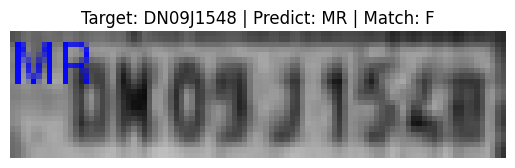

Showing image 1, label: [20], target: tensor([22., 17.,  1.,  4., 29., 12., 15.,  4.,  5.,  9.])


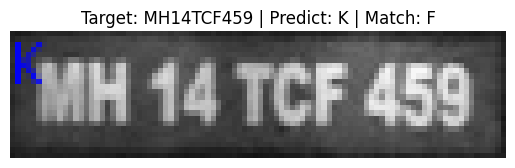

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.016625626520677048s 1/88]
Epoch:5 || epochiter: 4/24|| Totel iter 100 || Loss: 17.5581||Batch time: 0.5741 sec. ||LR: 0.00100000
Epoch:6 || epochiter: 0/24|| Totel iter 120 || Loss: 19.6509||Batch time: 1.3789 sec. ||LR: 0.00100000
Epoch:6 || epochiter: 20/24|| Totel iter 140 || Loss: 10.3025||Batch time: 0.5530 sec. ||LR: 0.00100000
Epoch:7 || epochiter: 16/24|| Totel iter 160 || Loss: 10.8088||Batch time: 0.5609 sec. ||LR: 0.00100000
Epoch:8 || epochiter: 12/24|| Totel iter 180 || Loss: 9.0631||Batch time: 0.5542 sec. ||LR: 0.00100000
Epoch:16 || epochiter: 0/24|| Totel iter 360 || Loss: 4.0596||Batch time: 1.3532 sec. ||LR: 0.00100000
Epoch:16 || epochiter: 20/24|| Totel iter 380 || Loss: 4.2403||Batch time: 0.5561 sec. ||LR: 0.00100000
Showing image 0, label: [17], target: tensor([13., 23.,  0.,  9., 12.,  0.,  8.,  6.,  8.])


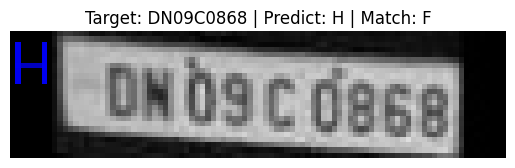

Showing image 1, label: [17], target: tensor([20., 10.,  0.,  5., 17., 28.,  4.,  4.,  9.,  5.])


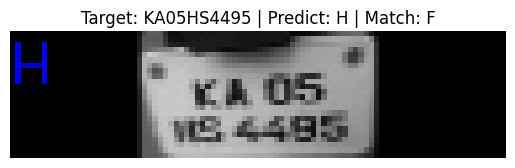

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.014295266433195635s 1/88]
Epoch:17 || epochiter: 16/24|| Totel iter 400 || Loss: 4.9459||Batch time: 0.5750 sec. ||LR: 0.00100000
Epoch:18 || epochiter: 12/24|| Totel iter 420 || Loss: 4.9870||Batch time: 0.5644 sec. ||LR: 0.00100000
Epoch:19 || epochiter: 8/24|| Totel iter 440 || Loss: 3.6914||Batch time: 0.5546 sec. ||LR: 0.00100000
Epoch:20 || epochiter: 4/24|| Totel iter 460 || Loss: 4.1485||Batch time: 0.5723 sec. ||LR: 0.00010000
Epoch:21 || epochiter: 0/24|| Totel iter 480 || Loss: 5.7500||Batch time: 1.3890 sec. ||LR: 0.00010000
Showing image 0, label: [], target: tensor([22., 17.,  2.,  0., 13., 31.,  2.,  3.,  6.,  2.])


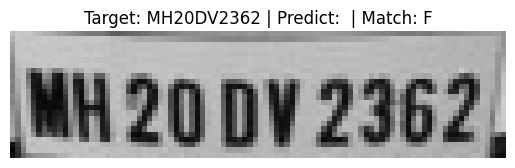

Showing image 1, label: [], target: tensor([29., 27.,  0.,  7., 13.,  0.,  5.,  6.,  9.])


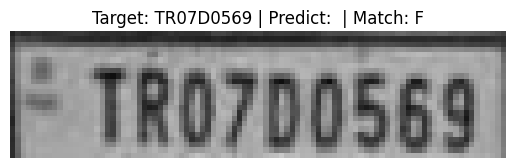

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.014290132305838844s 1/88]
Epoch:21 || epochiter: 20/24|| Totel iter 500 || Loss: 3.5165||Batch time: 0.5906 sec. ||LR: 0.00010000
Epoch:22 || epochiter: 16/24|| Totel iter 520 || Loss: 4.0228||Batch time: 0.5713 sec. ||LR: 0.00010000
Epoch:23 || epochiter: 12/24|| Totel iter 540 || Loss: 4.6680||Batch time: 0.5699 sec. ||LR: 0.00010000
Epoch:24 || epochiter: 8/24|| Totel iter 560 || Loss: 3.5185||Batch time: 0.5592 sec. ||LR: 0.00010000
Epoch:25 || epochiter: 4/24|| Totel iter 580 || Loss: 4.8450||Batch time: 0.5727 sec. ||LR: 0.00010000
Showing image 0, label: [], target: tensor([29., 23.,  7.,  6., 31.,  1.,  9.,  7.,  8.])


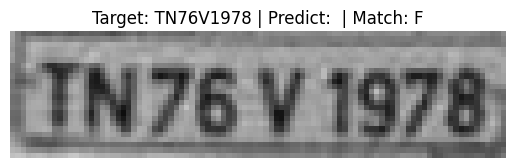

Showing image 1, label: [17], target: tensor([20., 10.,  0.,  5., 17., 28.,  4.,  4.,  9.,  5.])


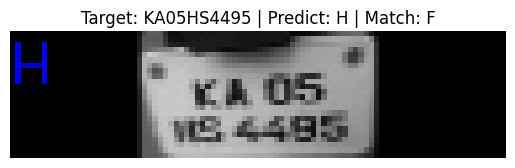

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.014565551822835749s 1/88]
Epoch:26 || epochiter: 0/24|| Totel iter 600 || Loss: 3.5131||Batch time: 1.4112 sec. ||LR: 0.00010000
Epoch:26 || epochiter: 20/24|| Totel iter 620 || Loss: 3.5317||Batch time: 0.5867 sec. ||LR: 0.00010000
Epoch:27 || epochiter: 16/24|| Totel iter 640 || Loss: 3.6858||Batch time: 0.5717 sec. ||LR: 0.00010000
Epoch:28 || epochiter: 12/24|| Totel iter 660 || Loss: 3.6070||Batch time: 0.5977 sec. ||LR: 0.00010000
Epoch:29 || epochiter: 8/24|| Totel iter 680 || Loss: 3.4423||Batch time: 0.6088 sec. ||LR: 0.00010000
Showing image 0, label: [], target: tensor([12., 16.,  0.,  7., 22., 10.,  2.,  5.,  2.,  9.])


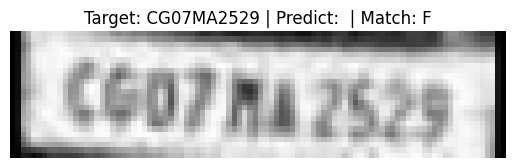

Showing image 1, label: [], target: tensor([22., 17.,  0.,  2., 13., 28.,  3.,  0.,  9.,  9.])


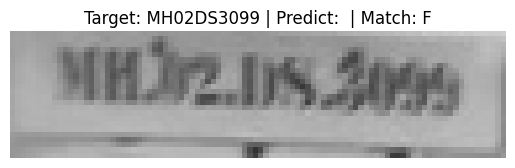

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.017245341431010853s 1/88]
Epoch:30 || epochiter: 4/24|| Totel iter 700 || Loss: 3.1841||Batch time: 0.6321 sec. ||LR: 0.00010000
Epoch:31 || epochiter: 0/24|| Totel iter 720 || Loss: 3.5425||Batch time: 1.3953 sec. ||LR: 0.00010000
Epoch:31 || epochiter: 20/24|| Totel iter 740 || Loss: 3.5689||Batch time: 0.5674 sec. ||LR: 0.00010000
Epoch:32 || epochiter: 16/24|| Totel iter 760 || Loss: 3.6538||Batch time: 0.5717 sec. ||LR: 0.00010000
Epoch:33 || epochiter: 12/24|| Totel iter 780 || Loss: 3.2889||Batch time: 0.5882 sec. ||LR: 0.00010000
Showing image 0, label: [17, 0], target: tensor([30., 25.,  1.,  6., 30.,  3.,  8.,  4.,  9.])


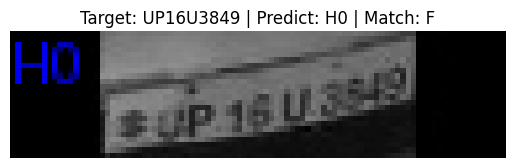

Showing image 1, label: [], target: tensor([10., 28.,  0.,  4., 25.,  4.,  5.,  4.,  9.])


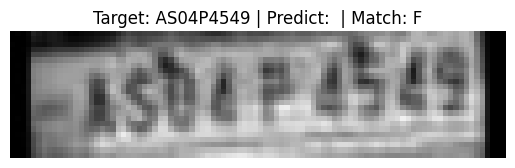

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.0165102481842041s 1/88]
Epoch:34 || epochiter: 8/24|| Totel iter 800 || Loss: 5.5025||Batch time: 0.5778 sec. ||LR: 0.00010000
Epoch:35 || epochiter: 4/24|| Totel iter 820 || Loss: 3.3609||Batch time: 0.5884 sec. ||LR: 0.00010000
Epoch:36 || epochiter: 0/24|| Totel iter 840 || Loss: 3.5009||Batch time: 1.3764 sec. ||LR: 0.00010000
Epoch:36 || epochiter: 20/24|| Totel iter 860 || Loss: 3.6061||Batch time: 0.5724 sec. ||LR: 0.00010000
Epoch:37 || epochiter: 16/24|| Totel iter 880 || Loss: 3.7323||Batch time: 0.5758 sec. ||LR: 0.00010000
Showing image 0, label: [], target: tensor([20., 21.,  2.,  7., 13.,  9.,  8.,  0.,  9.])


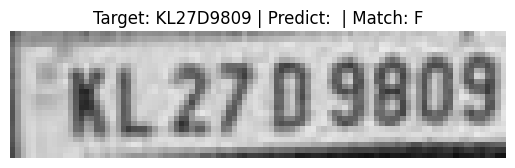

Showing image 1, label: [], target: tensor([10., 28.,  0.,  1., 11., 15.,  9.,  6.,  7.,  3.])


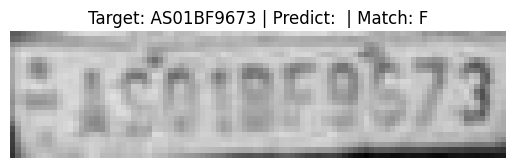

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.014368460936979814s 1/88]
Epoch:38 || epochiter: 12/24|| Totel iter 900 || Loss: 3.5020||Batch time: 0.5717 sec. ||LR: 0.00010000
Epoch:39 || epochiter: 8/24|| Totel iter 920 || Loss: 3.4816||Batch time: 0.5967 sec. ||LR: 0.00010000
Epoch:40 || epochiter: 4/24|| Totel iter 940 || Loss: 3.3770||Batch time: 0.5652 sec. ||LR: 0.00000000
Epoch:41 || epochiter: 0/24|| Totel iter 960 || Loss: 3.3458||Batch time: 1.3693 sec. ||LR: 0.00000000
Epoch:41 || epochiter: 20/24|| Totel iter 980 || Loss: 3.3660||Batch time: 0.6133 sec. ||LR: 0.00000000
Showing image 0, label: [], target: tensor([29., 23.,  2.,  1., 29., 12.,  3.,  1.])


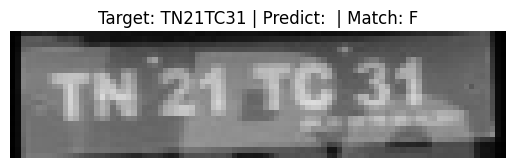

Showing image 1, label: [], target: tensor([10., 28.,  2.,  3., 17.,  2.,  8.,  6.,  6.])


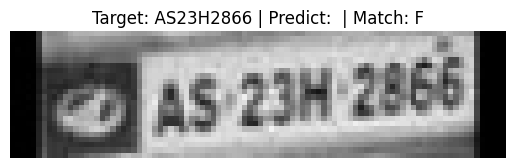

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.0144581984389912s 1/88]
Epoch:42 || epochiter: 16/24|| Totel iter 1000 || Loss: 3.3068||Batch time: 0.5904 sec. ||LR: 0.00000000
Epoch:43 || epochiter: 12/24|| Totel iter 1020 || Loss: 3.7311||Batch time: 0.5801 sec. ||LR: 0.00000000
Epoch:44 || epochiter: 8/24|| Totel iter 1040 || Loss: 3.3627||Batch time: 0.5624 sec. ||LR: 0.00000000
Epoch:45 || epochiter: 4/24|| Totel iter 1060 || Loss: 3.3223||Batch time: 0.5639 sec. ||LR: 0.00000000
Epoch:46 || epochiter: 0/24|| Totel iter 1080 || Loss: 3.6583||Batch time: 1.3744 sec. ||LR: 0.00000000
Showing image 0, label: [17], target: tensor([22., 17.,  0.,  1., 12., 29.,  9.,  1.,  5.,  0.])


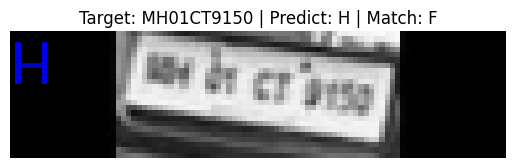

Showing image 1, label: [], target: tensor([32., 11.,  0.,  6., 19.,  4.,  4.,  3.,  2.])


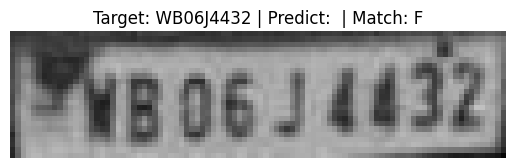

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.014221884987571022s 1/88]
Epoch:46 || epochiter: 20/24|| Totel iter 1100 || Loss: 3.9927||Batch time: 0.5856 sec. ||LR: 0.00000000
Epoch:47 || epochiter: 16/24|| Totel iter 1120 || Loss: 3.3887||Batch time: 0.5957 sec. ||LR: 0.00000000
Epoch:48 || epochiter: 12/24|| Totel iter 1140 || Loss: 3.3823||Batch time: 0.5550 sec. ||LR: 0.00000000
Epoch:49 || epochiter: 8/24|| Totel iter 1160 || Loss: 3.3831||Batch time: 0.5745 sec. ||LR: 0.00000000
Epoch:50 || epochiter: 4/24|| Totel iter 1180 || Loss: 3.3897||Batch time: 0.5782 sec. ||LR: 0.00000000
Showing image 0, label: [], target: tensor([22., 17.,  2.,  0., 11., 34.,  3.,  6.,  6.,  5.])


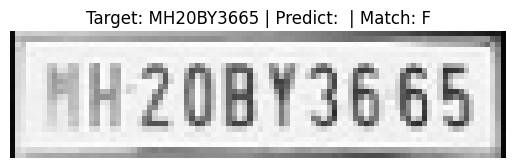

Showing image 1, label: [], target: tensor([22., 17.,  2.,  0., 13., 31.,  2.,  3.,  6.,  2.])


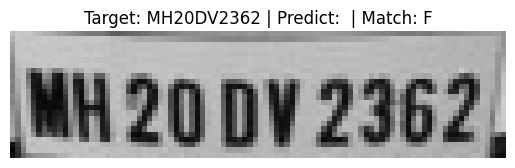

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.018862504850734364s 1/88]
Final test Accuracy:
Showing image 0, label: [], target: tensor([16., 10.,  0.,  6., 14.,  3.,  8.,  5.,  5.])


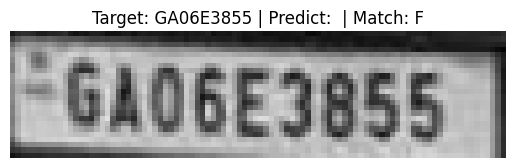

Showing image 1, label: [], target: tensor([32., 11.,  0.,  6., 19.,  4.,  4.,  3.,  2.])


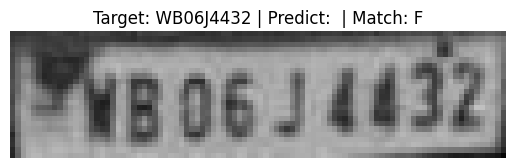

[Info] Test Accuracy: 0.0 [0:32:0:32]
[Info] Test Speed: 0.014532709663564508s 1/88]


In [170]:
train()

# Testing

In [158]:
import argparse
import sys

def get_parser():
    parser = argparse.ArgumentParser(description='Parameters to train the LPRNet model.')
    
    parser.add_argument('--img_size', type=int, nargs=2, default=(94, 24),
                        help='The image size as two integers, width and height.')
    parser.add_argument('--test_img_dirs', default="/kaggle/working/processed_images/test",
                        help='Path to the test images directory.')
    parser.add_argument('--dropout_rate', type=float, default=0.0,
                        help='Dropout rate for the model.')
    parser.add_argument('--lpr_max_len', type=int, default=15,
                        help='Maximum length of the license plate number.')
    parser.add_argument('--test_batch_size', type=int, default=22,
                        help='Testing batch size.')
    parser.add_argument('--phase_train', type=bool, default=False,
                        help='Train or test phase flag (True for training, False for testing).')
    parser.add_argument('--num_workers', type=int, default=8,
                        help='Number of workers used in data loading.')
    parser.add_argument('--cuda', type=bool, default=True,
                        help='Use CUDA for training the model.')
    parser.add_argument('--show', type=bool, default=True,
                        help='Whether to show test images and their predicted results.')
    parser.add_argument('--pretrained_model', 
                        default='/kaggle/input/pretrained/Final_LPRNet_model.pth',
                        help='Path to the pretrained model.')

    # Check if we are running in Jupyter Notebook
    if 'ipykernel' in sys.modules:
        return parser.parse_args([])  # Parse with no arguments for Jupyter

    return parser.parse_args()  # Normal parsing for command line


In [159]:
def Greedy_Decode_Eval(Net, datasets, args):
    epoch_size = len(datasets) // args.test_batch_size
    batch_iterator = iter(DataLoader(datasets, args.test_batch_size, shuffle=True, num_workers=args.num_workers, collate_fn=collate_fn))

    Tp = 0
    Tn_1 = 0
    Tn_2 = 0
    t1 = time.time()

    for i in range(epoch_size):
        images, labels, lengths = next(batch_iterator)
        start = 0
        
        # Creating targets as an object array to accommodate varying lengths
        targets = np.empty(len(lengths), dtype=object)
        for idx, length in enumerate(lengths):
            targets[idx] = labels[start:start + length]
            start += length
        
        imgs = images.numpy().copy()

        if args.cuda:
            images = Variable(images.cuda())
        else:
            images = Variable(images)

        # Forward pass
        prebs = Net(images)
        prebs = prebs.cpu().detach().numpy()
        preb_labels = []

        for i in range(prebs.shape[0]):
            preb = prebs[i, :, :]
            preb_label = []
            for j in range(preb.shape[1]):
                preb_label.append(np.argmax(preb[:, j], axis=0))
            no_repeat_blank_label = []
            pre_c = preb_label[0]
            if pre_c != len(CHARS) - 1:
                no_repeat_blank_label.append(pre_c)
            for c in preb_label:
                if (pre_c == c) or (c == len(CHARS) - 1):
                    if c == len(CHARS) - 1:
                        pre_c = c
                    continue
                no_repeat_blank_label.append(c)
                pre_c = c
            preb_labels.append(no_repeat_blank_label)

        for i, label in enumerate(preb_labels):
            if args.show:
                print(f"Showing image {i}, label: {label}, target: {targets[i]}")
                if imgs[i].shape[0] == 0 or imgs[i].shape[1] == 0:
                    print(f"Empty image at index {i}, skipping...")
                    continue
                show(imgs[i], label, targets[i])
            if len(label) != len(targets[i]):
                Tn_1 += 1
                continue
            if (np.asarray(targets[i]) == np.asarray(label)).all():
                Tp += 1
            else:
                Tn_2 += 1

    total_predictions = Tp + Tn_1 + Tn_2
    Acc = Tp * 1.0 / total_predictions if total_predictions > 0 else 0.0
    
    print("[Info] Test Accuracy: {} [{}:{}:{}:{}]".format(Acc, Tp, Tn_1, Tn_2, total_predictions))
    t2 = time.time()
    print("[Info] Test Speed: {}s 1/{}]".format((t2 - t1) / len(datasets), len(datasets)))


In [160]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Function to show the image with label and target
def show(img, label, target):
    # Transpose and adjust the image
    img = np.transpose(img, (1, 2, 0))
    img *= 128.
    img += 127.5
    img = img.astype(np.uint8)

    lb = ""
    for i in label:
        lb += CHARS[i]  # Assuming CHARS is predefined
    tg = ""
    for j in target.tolist():
        tg += CHARS[int(j)]

    flag = "T" if lb == tg else "F"

    # Add text to the image
    img = cv2ImgAddText(img, lb, (0, 0))
    
    # Display image using matplotlib
    plt.imshow(img)
    plt.title(f"Target: {tg} | Predict: {lb} | Match: {flag}")
    plt.axis('off')  # Hide axis
    plt.show()

def cv2ImgAddText(img, text, pos, textColor=(255, 0, 0), textSize=12):
    if isinstance(img, np.ndarray):  # Check if it's a valid OpenCV image format
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to PIL format
    draw = ImageDraw.Draw(img)
    # Use a default font
    fontText = ImageFont.load_default()  # Use default font
    draw.text(pos, text, textColor, font=fontText)

    return cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)

In [161]:
def test():
    args = get_parser()

    lprnet = build_lprnet(lpr_max_len=args.lpr_max_len, phase=args.phase_train, class_num=len(CHARS), dropout_rate=args.dropout_rate)
    device = torch.device("cuda:0" if args.cuda else "cpu")
    lprnet.to(device)
    print("Successful to build network!")

    # load pretrained model
    if args.pretrained_model:
        lprnet.load_state_dict(torch.load(args.pretrained_model))
        print("load pretrained model successful!")
    else:
        print("[Error] Can't find pretrained mode, please check!")
        return False

    test_img_dirs = os.path.expanduser(args.test_img_dirs)
    test_dataset = LPRDataLoader(test_img_dirs.split(','), args.img_size, args.lpr_max_len)
    try:
        Greedy_Decode_Eval(lprnet, test_dataset, args)
    finally:
#         cv2.destroyAllWindows()
        pass


Successful to build network!
load pretrained model successful!
1dir found, size:  88


/tmp/ipykernel_92/261190705.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lprnet.load_state_dict(torch.load(args.pretrained_model))
/opt/conda/lib/python3.10/site-pac

Showing image 0, label: [21], target: tensor([30., 25.,  5.,  0., 10., 28.,  4.,  5.,  3.,  5.])


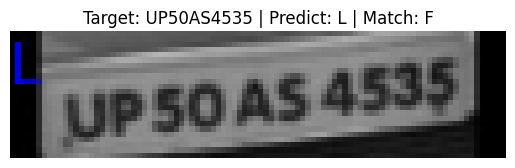

Showing image 1, label: [21, 21], target: tensor([29., 23.,  0.,  9., 12., 17.,  7.,  7.,  7.,  0.])


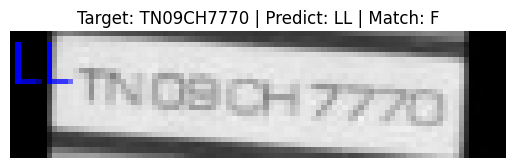

Showing image 2, label: [21, 21], target: tensor([22., 17.,  4.,  3., 10., 21.,  8.,  4.,  6.,  4.])


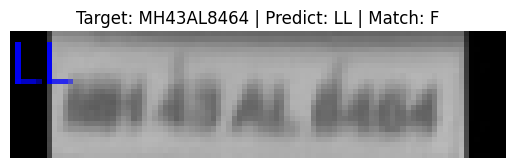

Showing image 3, label: [], target: tensor([29., 23.,  2.,  1., 29., 12.,  3.,  1.])


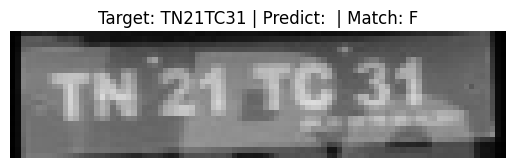

Showing image 4, label: [21, 21], target: tensor([22., 17.,  0.,  3., 10., 22.,  3.,  0.,  2.,  5.])


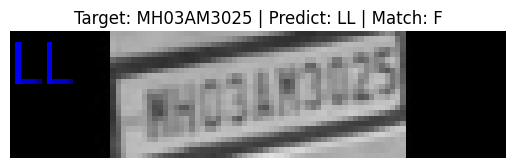

Showing image 5, label: [], target: tensor([10., 28.,  0.,  1., 11., 15.,  9.,  6.,  7.,  3.])


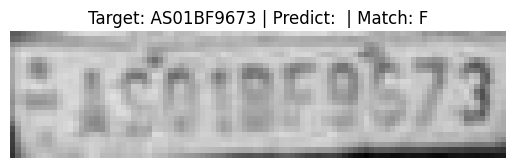

Showing image 6, label: [], target: tensor([24., 13.,  2.,  5., 15.,  7.,  4.,  0.,  0.])


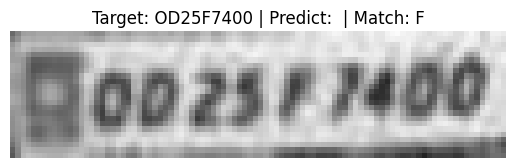

Showing image 7, label: [], target: tensor([30., 25.,  1.,  4., 10., 20.,  8.,  6.,  0.,  4.])


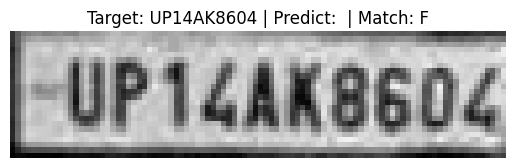

Showing image 8, label: [], target: tensor([22., 17.,  0.,  1., 13., 11.,  2.,  5.,  6.,  1.])


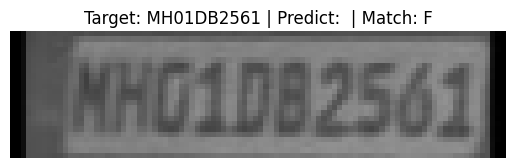

Showing image 9, label: [], target: tensor([29., 27.,  0.,  7., 13.,  0.,  5.,  6.,  9.])


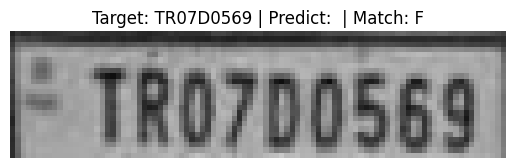

Showing image 10, label: [], target: tensor([29., 23.,  1.,  9., 26.,  0.,  8.,  3.,  5.])


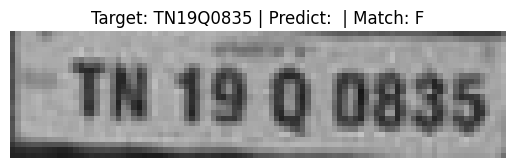

Showing image 11, label: [], target: tensor([22., 17.,  2.,  0., 14., 14.,  7.,  5.,  9.,  7.])


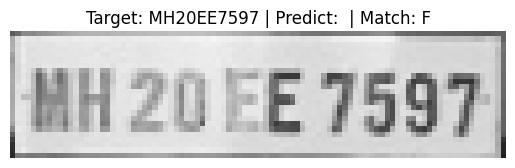

Showing image 12, label: [], target: tensor([22., 17.,  2.,  0., 11., 34.,  3.,  6.,  6.,  5.])


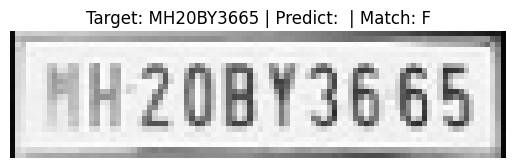

Showing image 13, label: [], target: tensor([22., 21.,  0.,  5., 12.,  5.,  3.,  8.,  9.])


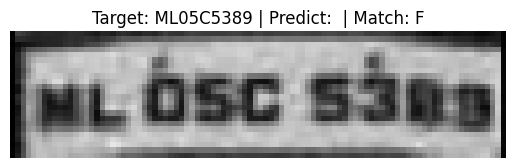

Showing image 14, label: [21, 21], target: tensor([16., 10.,  0.,  5., 11.,  5.,  0.,  7.,  7.])


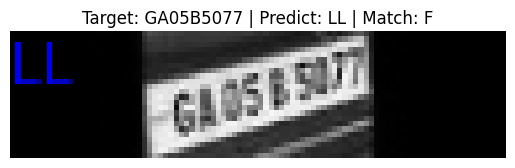

Showing image 15, label: [], target: tensor([20., 21.,  2.,  7., 13.,  9.,  8.,  0.,  9.])


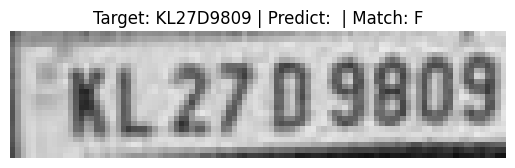

Showing image 16, label: [], target: tensor([32., 11.,  0.,  6., 19.,  4.,  4.,  3.,  2.])


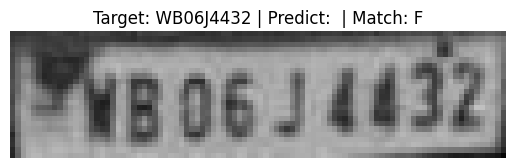

Showing image 17, label: [21, 21], target: tensor([22., 17.,  0.,  1., 12., 29.,  9.,  1.,  5.,  0.])


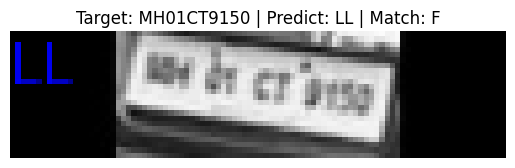

Showing image 18, label: [], target: tensor([19., 20.,  0.,  2., 11., 15.,  5.,  0.,  5.,  8.])


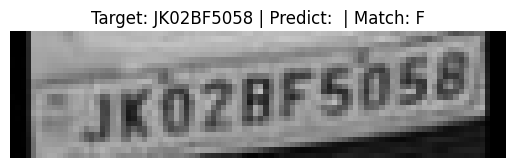

Showing image 19, label: [], target: tensor([16., 19.,  0.,  1., 17., 28.,  1.,  9.,  0.,  2.])


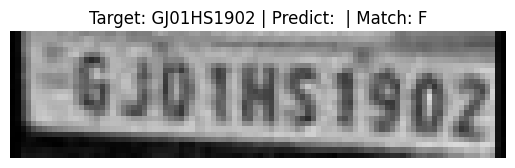

Showing image 20, label: [], target: tensor([27., 19.,  2.,  0., 30., 11.,  0.,  1.,  3.,  7.])


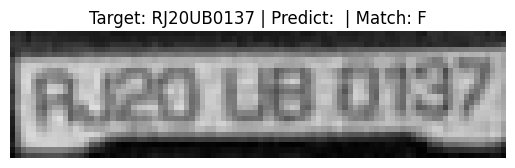

Showing image 21, label: [21, 21], target: tensor([23., 21.,  0.,  2., 12.,  9.,  5.,  9.,  3.])


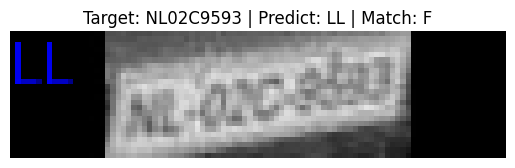

Showing image 0, label: [], target: tensor([22., 17.,  0.,  3., 12., 11.,  6.,  4.,  6.,  7.])


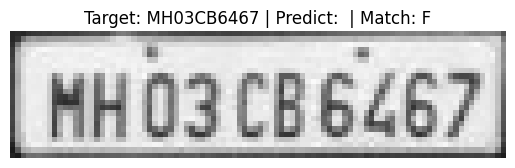

Showing image 1, label: [], target: tensor([12., 16.,  0.,  7., 22., 10.,  2.,  5.,  2.,  9.])


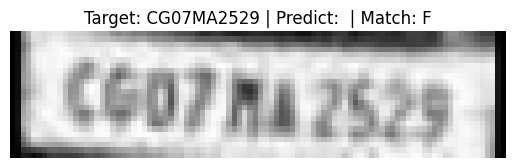

Showing image 2, label: [21, 21], target: tensor([22., 17.,  0.,  3., 10., 29.,  3.,  8.,  5.,  6.])


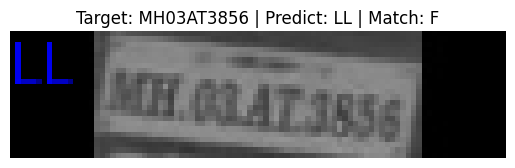

Showing image 3, label: [], target: tensor([30., 25.,  7.,  8., 14., 13.,  0.,  4.,  4.,  9.])


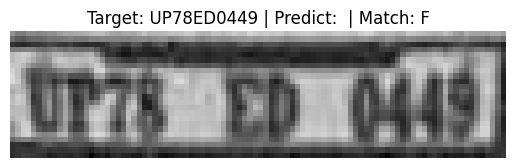

Showing image 4, label: [], target: tensor([29., 28.,  2.,  1., 19.,  8.,  3.,  5.,  1.])


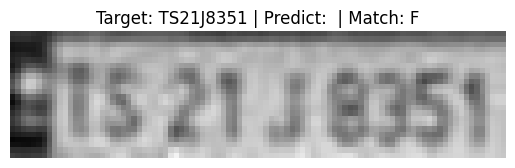

Showing image 5, label: [21, 21], target: tensor([22., 17.,  0.,  2., 13., 23.,  6.,  9.,  8.,  0.])


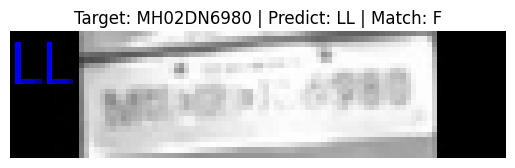

Showing image 6, label: [], target: tensor([19., 20.,  0.,  2., 11., 23.,  3.,  0.,  8.,  8.])


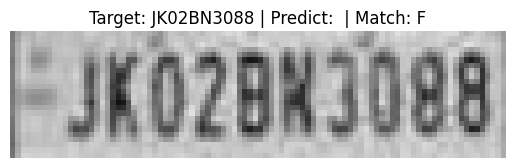

Showing image 7, label: [], target: tensor([22., 17.,  0.,  5., 14., 19.,  3.,  0.,  0.,  5.])


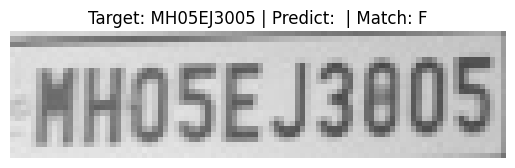

Showing image 8, label: [21, 21], target: tensor([22., 17.,  1.,  2., 15., 30.,  1.,  0.,  1.,  4.])


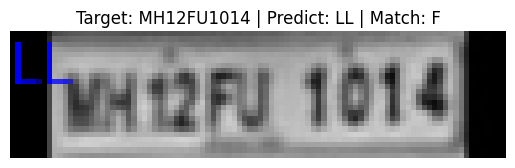

Showing image 9, label: [21, 21], target: tensor([29., 23.,  2.,  1., 10., 29.,  0.,  4.,  8.,  0.])


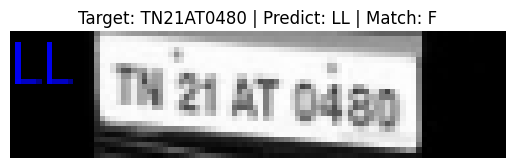

Showing image 10, label: [21, 21], target: tensor([20., 10.,  0.,  5., 17., 28.,  4.,  4.,  9.,  5.])


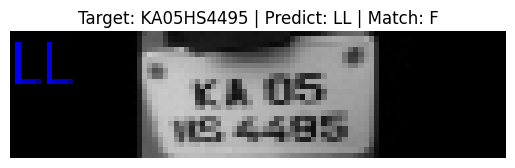

Showing image 11, label: [21], target: tensor([22., 17.,  0.,  2., 11., 26.,  9.,  6.,  2.,  8.])


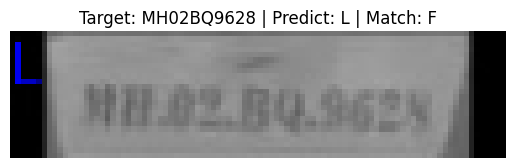

Showing image 12, label: [], target: tensor([22., 17.,  0.,  2., 11., 22.,  5.,  0.,  4.,  8.])


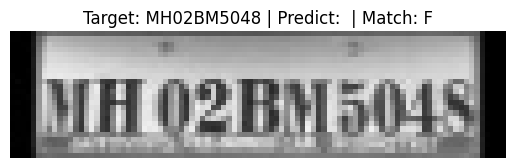

Showing image 13, label: [], target: tensor([28., 20.,  0.,  1., 25., 10.,  2.,  9.,  6.,  9.])


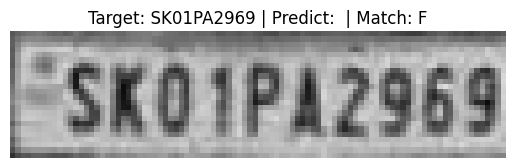

Showing image 14, label: [], target: tensor([24., 13.,  0.,  1., 26.,  4.,  6.,  6.,  8.])


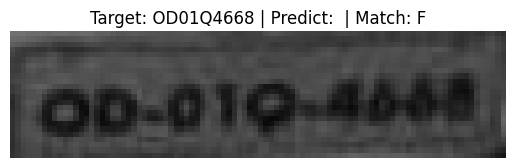

Showing image 15, label: [], target: tensor([20., 10.,  0.,  3., 22., 33.,  5.,  0.,  5.,  8.])


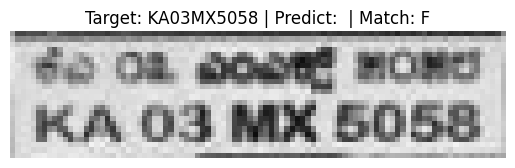

Showing image 16, label: [21], target: tensor([17., 27.,  2.,  6., 12., 29.,  4.,  0.,  6.,  3.])


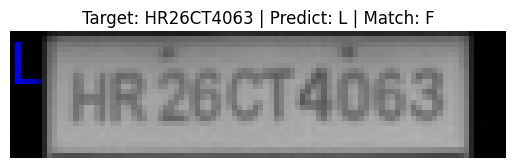

Showing image 17, label: [], target: tensor([29., 23.,  7.,  6., 31.,  1.,  9.,  7.,  8.])


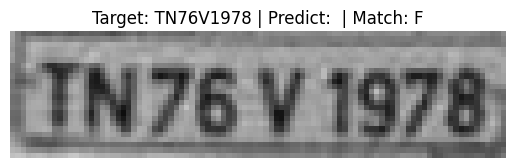

Showing image 18, label: [21], target: tensor([20., 10.,  5.,  1., 22., 19.,  8.,  1.,  5.,  6.])


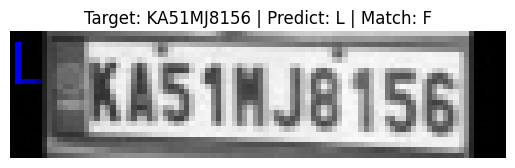

Showing image 19, label: [21, 21], target: tensor([20., 21.,  0.,  1., 12., 12.,  5.,  0.])


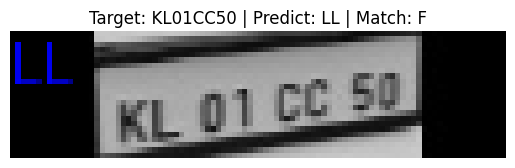

Showing image 20, label: [], target: tensor([16., 19.,  1.,  6., 12., 17.,  9.,  8.,  2.,  7.])


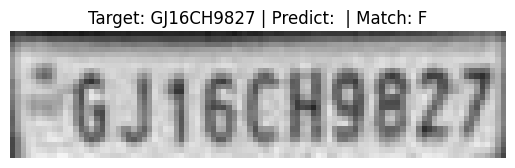

Showing image 21, label: [], target: tensor([32., 11.,  0.,  2., 22.,  8.,  4.,  4.,  7.])


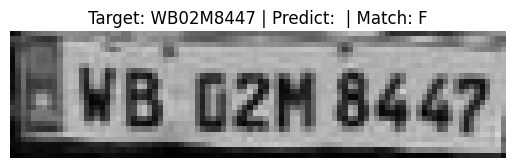

Showing image 0, label: [], target: tensor([30., 25.,  1.,  1., 10., 34.,  0.,  6.,  4.,  6.])


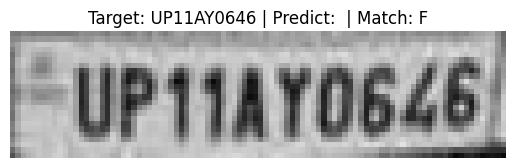

Showing image 1, label: [], target: tensor([25., 34.,  0.,  5., 10.,  8.,  3.,  3.,  9.])


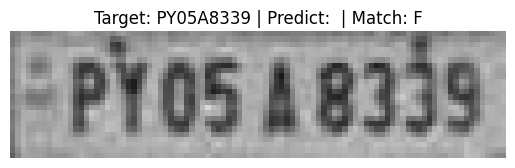

Showing image 2, label: [], target: tensor([20., 21.,  6.,  0., 23.,  5.,  3.,  4.,  4.])


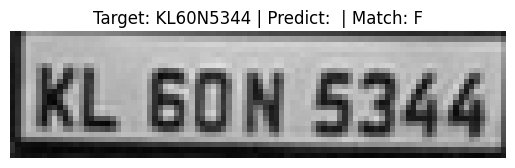

Showing image 3, label: [], target: tensor([22., 17.,  1.,  2., 20., 34.,  6.,  9.,  2.,  1.])


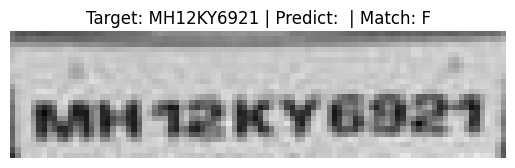

Showing image 4, label: [], target: tensor([20., 21.,  4.,  3., 13.,  4.,  3.,  8.,  9.])


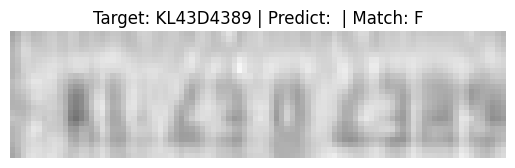

Showing image 5, label: [], target: tensor([30., 20.,  0.,  7., 10., 22.,  5.,  6.,  6.,  5.])


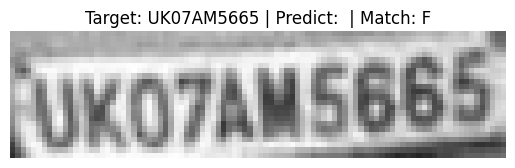

Showing image 6, label: [], target: tensor([11., 27.,  3.,  2., 25., 10.,  6.,  5.,  5.,  8.])


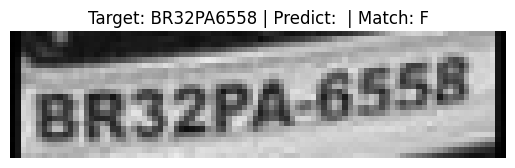

Showing image 7, label: [21, 21], target: tensor([22., 17.,  2.,  0., 14., 30.,  9.,  9.,  9.,  1.])


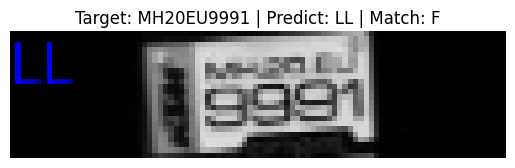

Showing image 8, label: [21, 21], target: tensor([22., 17.,  0.,  2., 10., 26.,  2.,  2.,  9.,  9.])


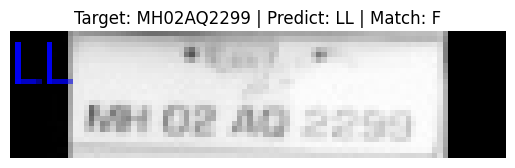

Showing image 9, label: [21, 21], target: tensor([22., 17.,  0.,  2., 14., 30.,  4.,  0.,  7.,  7.])


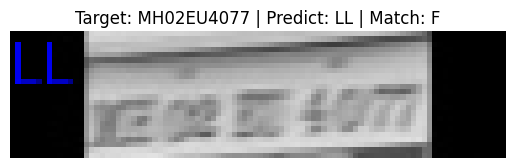

Showing image 10, label: [], target: tensor([29., 23.,  0.,  7., 11., 30.,  5.,  4.,  2.,  7.])


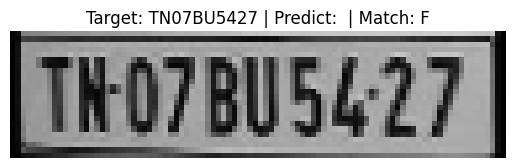

Showing image 11, label: [21, 21], target: tensor([22., 17.,  0.,  2., 14., 25.,  4.,  4.,  5.,  4.])


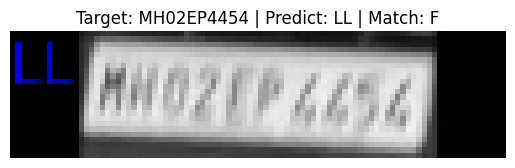

Showing image 12, label: [21, 21], target: tensor([22., 17.,  0.,  2., 11., 27.,  4.,  5.,  0.,  3.])


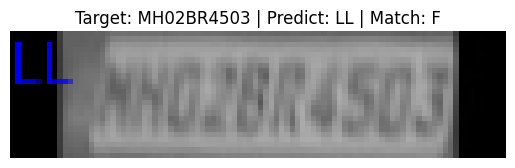

Showing image 13, label: [], target: tensor([12., 16.,  1.,  3., 10., 14.,  4.,  0.,  6.,  0.])


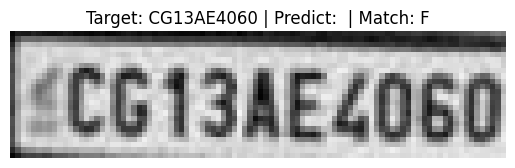

Showing image 14, label: [], target: tensor([16., 10.,  0.,  6., 14.,  3.,  8.,  5.,  5.])


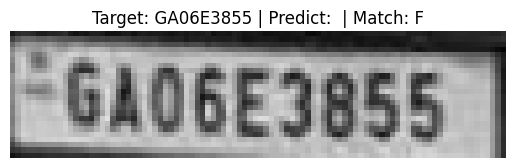

Showing image 15, label: [], target: tensor([17., 27.,  2.,  6., 11., 25.,  3.,  5.,  4.,  3.])


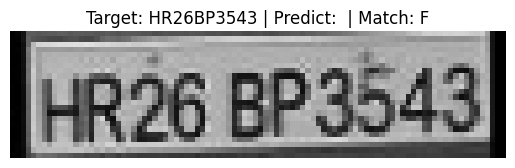

Showing image 16, label: [], target: tensor([19., 17.,  0.,  1., 11., 12.,  5.,  2.,  1.,  0.])


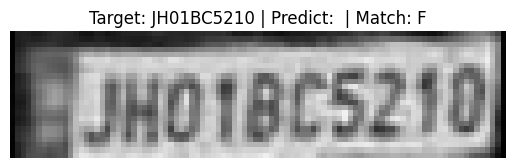

Showing image 17, label: [], target: tensor([22., 17.,  0.,  2., 13., 28.,  3.,  0.,  9.,  9.])


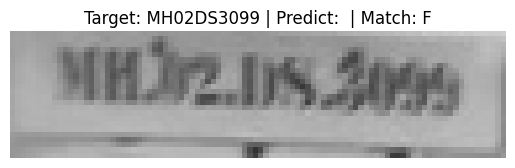

Showing image 18, label: [], target: tensor([25., 34.,  0.,  1., 10., 32.,  2.,  8.,  1.,  4.])


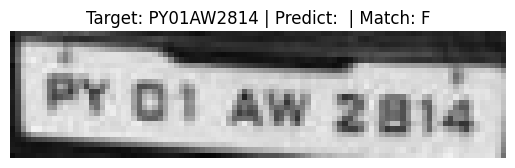

Showing image 19, label: [], target: tensor([22., 17.,  1.,  2., 23., 19.,  5.,  8.,  3.,  8.])


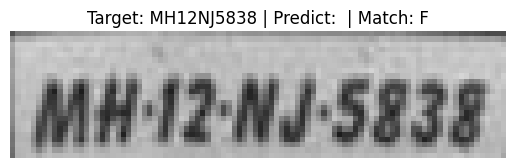

Showing image 20, label: [], target: tensor([10., 25.,  5., 12., 16.,  6.,  3.,  2.,  0.])


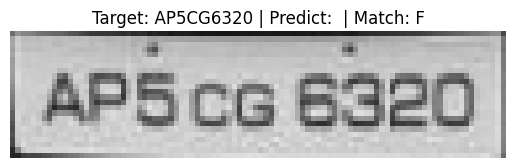

Showing image 21, label: [21], target: tensor([22., 17.,  0.,  3., 13., 31.,  2.,  0.,  1.,  0.])


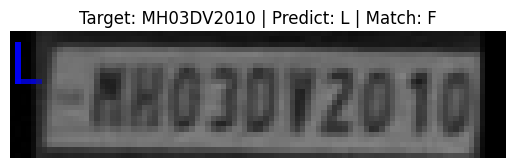

Showing image 0, label: [], target: tensor([25., 34.,  0.,  2., 28.,  9.,  3.,  2.,  6.])


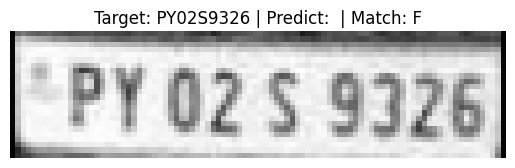

Showing image 1, label: [], target: tensor([22., 17.,  3.,  6., 17.,  5.,  7.,  0.,  0.])


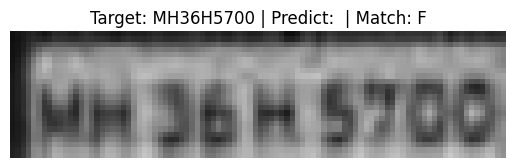

Showing image 2, label: [], target: tensor([12., 17.,  0.,  1., 11., 26.,  5.,  6.,  0.,  4.])


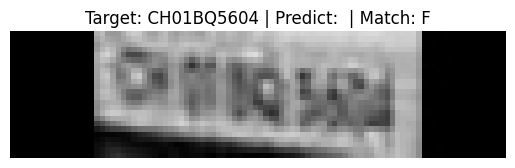

Showing image 3, label: [], target: tensor([29., 27.,  0.,  1., 23.,  0.,  4.,  8.,  1.])


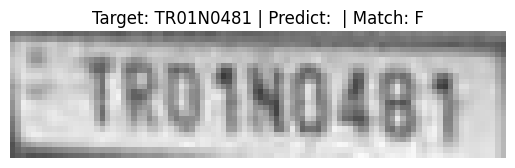

Showing image 4, label: [], target: tensor([16., 19.,  1.,  5., 12., 13.,  0.,  5.,  6.,  4.])


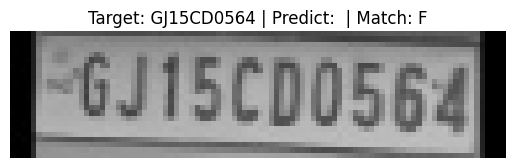

Showing image 5, label: [], target: tensor([24., 13.,  0.,  5., 34.,  5.,  7.,  8.,  7.])


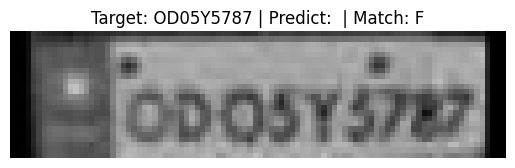

Showing image 6, label: [], target: tensor([10., 28.,  2.,  3., 17.,  2.,  8.,  6.,  6.])


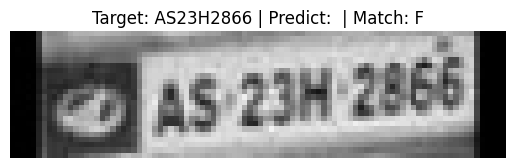

Showing image 7, label: [], target: tensor([20., 10.,  1.,  8., 25.,  2.,  9.,  8.,  7.])


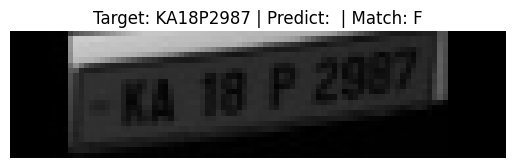

Showing image 8, label: [], target: tensor([17., 27.,  2.,  6., 29., 12.,  5.,  6.,  5.,  6.])


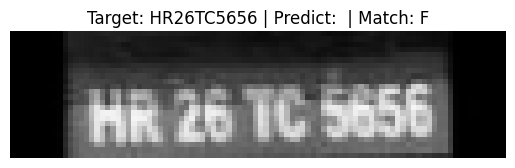

Showing image 9, label: [], target: tensor([13., 23.,  0.,  9., 19.,  1.,  5.,  4.,  8.])


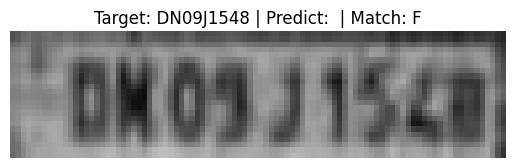

Showing image 10, label: [], target: tensor([29., 23.,  2.,  1., 11., 35.,  0.,  7.,  6.,  8.])


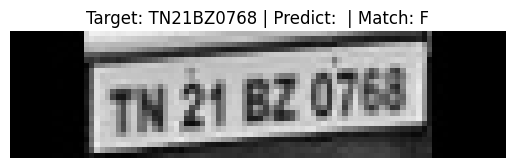

Showing image 11, label: [], target: tensor([22., 25.,  0.,  4., 12., 21.,  3.,  5.,  4.,  6.])


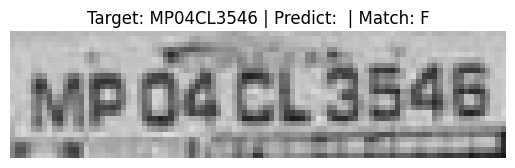

Showing image 12, label: [], target: tensor([22., 17.,  2.,  0., 13., 31.,  2.,  3.,  6.,  2.])


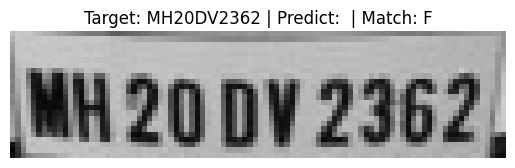

Showing image 13, label: [], target: tensor([30., 25.,  1.,  6., 30.,  3.,  8.,  4.,  9.])


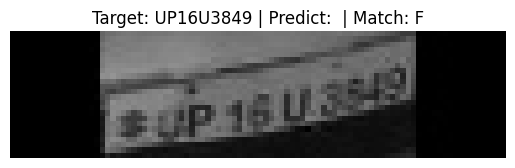

Showing image 14, label: [], target: tensor([16., 19.,  0.,  6., 13., 26.,  3.,  7.,  1.,  2.])


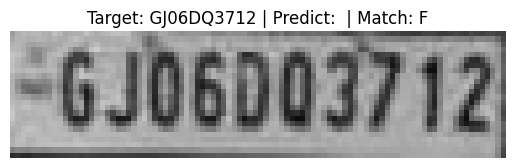

Showing image 15, label: [], target: tensor([19., 17.,  1.,  0., 28.,  5.,  3.,  7.,  8.])


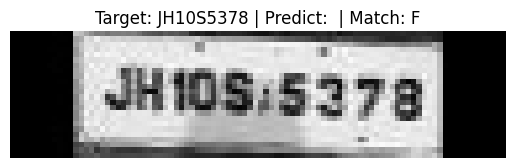

Showing image 16, label: [], target: tensor([22., 17.,  1.,  4., 29., 12., 15.,  4.,  5.,  9.])


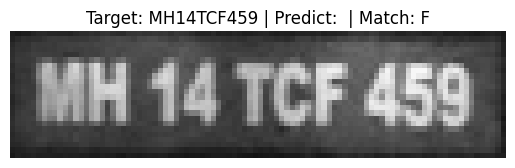

Showing image 17, label: [], target: tensor([16., 10.,  0.,  1., 28.,  5.,  5.,  9.,  4.])


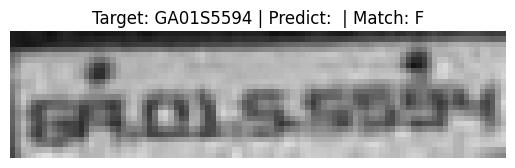

Showing image 18, label: [], target: tensor([13., 23.,  0.,  9., 12.,  0.,  8.,  6.,  8.])


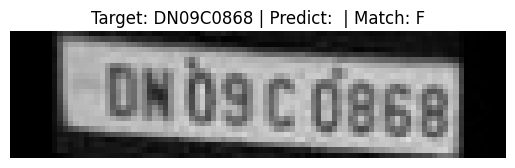

Showing image 19, label: [], target: tensor([22., 17.,  0.,  4., 14., 33.,  7.,  5.,  0.,  5.])


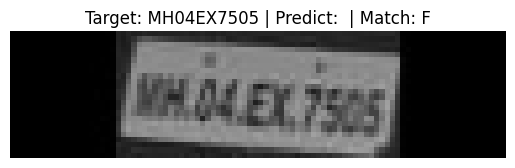

Showing image 20, label: [], target: tensor([10., 28.,  0.,  4., 25.,  4.,  5.,  4.,  9.])


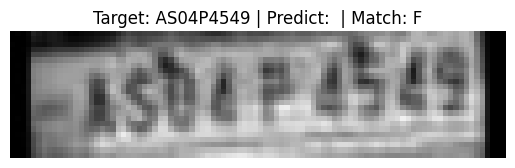

Showing image 21, label: [], target: tensor([22., 17.,  2.,  0., 11., 23.,  3.,  5.,  2.,  5.])


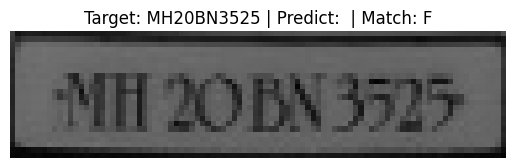

[Info] Test Accuracy: 0.0 [0:88:0:88]
[Info] Test Speed: 0.13423879850994458s 1/88]


In [162]:
test()